# Imports

In [1]:
#Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm



from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [4]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [5]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [6]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 2min 3s, sys: 15 s, total: 2min 18s
Wall time: 3min 30s


In [7]:
from tqdm import tqdm
import sys
import time

In [30]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt

# Data selection

In [9]:

import torch
from torch.utils import data
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]

        return (X, y)

In [10]:
width = 100

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████| 165/165 [00:00<00:00, 57705.34it/s]


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

['1_chr1' '1_chr1' '1_chr1' ... '0_chr18' '0_chr8' '0_chr6']


In [13]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

train_dataset = Dataset(chrom_names, feature_names,
                       DNA, DNA_features,
                       ZDNA, train_intervals)

test_dataset = Dataset(chrom_names, feature_names,
                       DNA, DNA_features,
                       ZDNA, test_intervals)

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# All models

In [14]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output

In [19]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(1950, 500, 2, bidirectional=True)
        self.seq = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(2 * 500, 500),
                    nn.Sigmoid(),
                    nn.Dropout(0.5),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.seq(x)
        return F.log_softmax(x, dim=-1)

# Train and test

In [32]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in tqdm(loader_train, desc='Train'):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in tqdm(loader_test, desc='Test'):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)

    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)

    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize),
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')

    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2),
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))

        start_time = time.time()

        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)

        end_time = time.time()
        t = end_time - start_time
        times.append(t)

        BatchSize = len(train_loss)

        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))

#         raise BaseException
        clear_output()
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss), n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss), n_epochs)
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss), n_epochs)
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss), n_epochs)
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss), n_epochs)
        print("Time: ", t/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))


    print("Final ROC-AUC = {:.4}".format(val_auc_log[-1]))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))
    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times

# DeepZ

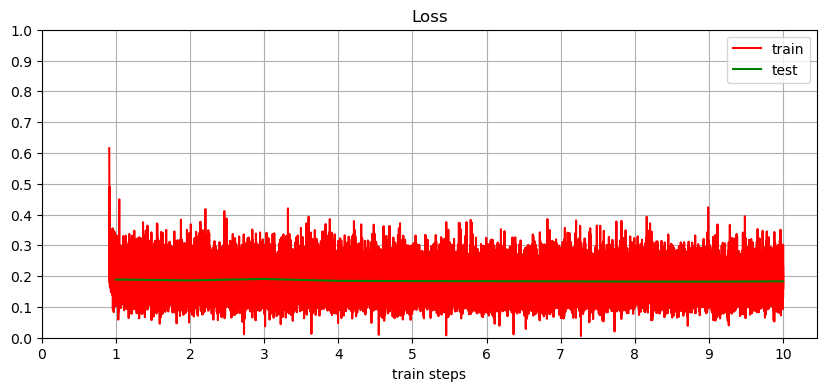

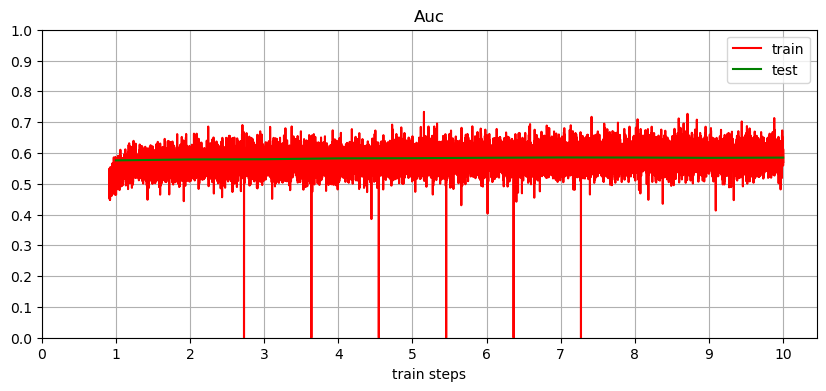

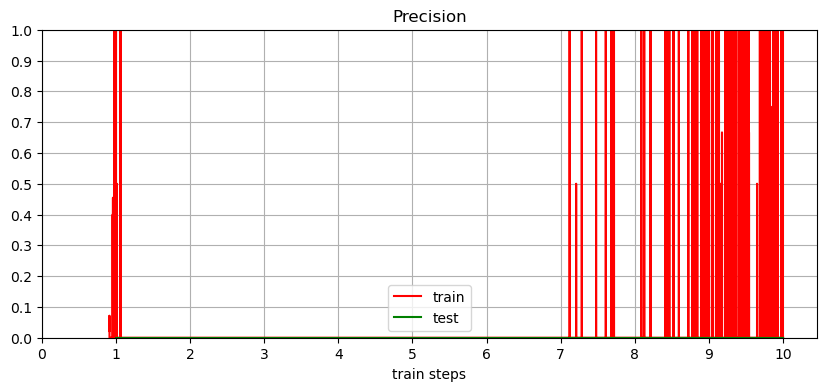

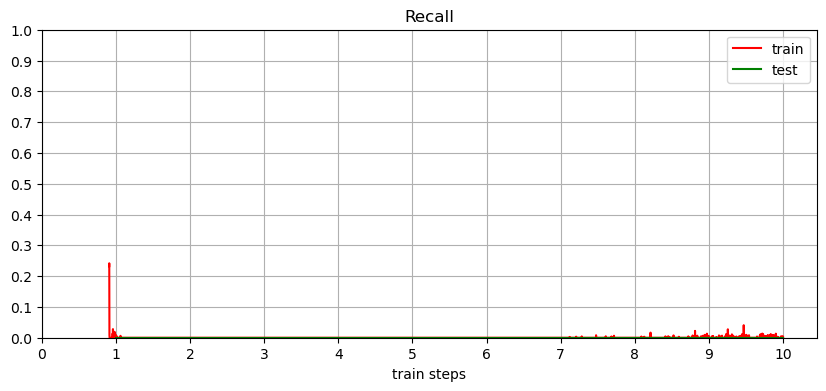

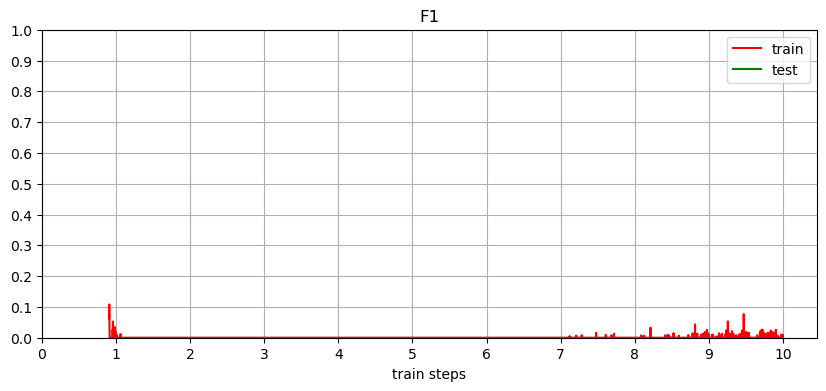

Time:  15.704306741555532
Epoch 10: ROC-AUC = 58.48%
Epoch 10: Precision = 0.0
Epoch 10: Recall = 0.0
Epoch 10: F1-score = 0.0
Final ROC-AUC = 0.5848
Final Precision = 0.0
Final Recall = 0.0
Final F1-score = 0.0
CPU times: user 31min 15s, sys: 16min 22s, total: 47min 38s
Wall time: 2h 32min 19s


In [33]:
%%time


set_random_seed(42)
model = DeepZ()
model = model.cuda()

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10)

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 1
Max F1-score: 0.0000
ROC-AUC: 0.5759
Precision: 0.0000
Recall: 0.0000
Mean time for 1 epoch 15.22 minutes
